In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scipy.ndimage import gaussian_filter1d

from retrieval_base.retrieval import pre_processing, prior_check, Retrieval
from retrieval_base.spectrum_jwst import SpectrumJWST
from retrieval_base.pRT_model import pRT_model
import retrieval_base.auxiliary_functions as aux
# import config_jwst as conf
from retrieval_base.config import Config


%load_ext autoreload
%autoreload 2

path = pathlib.Path('/home/dario/phd/retrieval_base/')
run = 'jwst_KLM_N10'
config_file = 'config_jwst.txt'
conf = Config(path=path, run=run, target='TWA28')(config_file)

conf.constant_params['N_knots'] = 1

In [2]:
ret = Retrieval(
        conf=conf, 
        evaluation=False,
        )
bestfit_params, posterior = ret.PMN_analyze()

res_id = np.argwhere(ret.Param.param_keys == 'res')[0][0]
bestfit_params[res_id] = 100e3
ret.evaluate_model(bestfit_params)
ret.PMN_lnL_func()



  analysing data from ./retrieval_outputs/jwst_KLM_N10/test_.txt
 log_a: 0.4812636789066165
 log_l: -0.19246257238574616
 rv: 10.289730929415548
 log_12CO: -5.007386309029708
 log_13CO: -6.431641581477821
 log_C18O: -7.239887874040089
 log_C17O: -7.943904562307726
 log_H2O: -4.57914410833726
 log_H2O_181: -7.614978146934343
 log_CO2: -9.127909092637296
 T_0: 4958.659741562088
 log_P_RCE: -0.21323441162372214
 dlog_P_1: 0.5320226725205714
 dlog_P_3: 0.5352787047334061
 dlnT_dlnP_RCE: 0.20086980707326585
 dlnT_dlnP_0: 0.052751121169335155
 dlnT_dlnP_1: 0.20064847966782565
 dlnT_dlnP_2: 0.04773900745256369
 dlnT_dlnP_3: 0.014406963405751204
 dlnT_dlnP_4: 0.03405255662773712
 dlnT_dlnP_5: 0.008968805296900573
 res: 100000.0


/home/dario/phd/retrieval_base/retrieval_base/spectrum.py:286: RuntimeWarning: invalid value encountered in sqrt
  sigma_LSF = np.sqrt(1/out_res**2 - 1/in_res**2) / \


217361.14017030073

In [16]:
def instr_broadening_old(wave, flux, out_res=1e6, in_res=1e6):
        """
        Broadens the spectrum by the instrumental resolution.

        Parameters:
        wave : ndarray
            Wavelength array.
        flux : ndarray
            Flux array.
        out_res : float, optional
            Output resolution (default is 1e6).
        in_res : float, optional
            Input resolution (default is 1e6).

        Returns:
        flux_LSF : ndarray
            Flux array after applying instrumental broadening.
        """
        # Delta lambda of resolution element is FWHM of the LSF's standard deviation
        sigma_LSF = np.sqrt(1/out_res**2 - 1/in_res**2) / (2 * np.sqrt(2 * np.log(2)))

        # Calculate the average spacing between wavelength points
        spacing = np.nanmean(2 * np.diff(wave) / (wave[1:] + wave[:-1]))

        # Calculate the sigma to be used in the gauss filter in pixels
        sigma_LSF_gauss_filter = sigma_LSF / spacing
        
        # Apply gaussian filter to broaden with the spectral resolution
        flux_LSF = gaussian_filter1d(flux, sigma=sigma_LSF_gauss_filter, mode='nearest')

        return flux_LSF

def instr_broadening_new(wave, 
                         flux, out_res, in_res=1e6):
    """
    Broadens the spectrum by the instrumental resolution that scales linearly with wavelength.

    Parameters:
    wave : ndarray
        Wavelength array.
    flux : ndarray
        Flux array.
    out_res : float
        Minimum output resolution at the start of the wavelength array.
    in_res : float, optional
        Input resolution (default is 1e6).

    Returns:
    flux_LSF : ndarray
        Flux array after applying instrumental broadening.
    """

    # Calculate the resolution array scaling linearly with wavelength
    out_res_array = out_res * (wave / wave[0])

    # Calculate the sigma for the LSF at each wavelength point
    sigma_LSF_array = np.sqrt(1/out_res_array**2 - 1/in_res**2) / (2 * np.sqrt(2 * np.log(2)))

    # Calculate the average spacing between wavelength points
    spacing = np.nanmean(2 * np.diff(wave) / (wave[1:] + wave[:-1]))

    # Convert the sigma_LSF to pixel units
    sigma_LSF_gauss_filter = sigma_LSF_array / spacing

    # Initialize an array for the broadened flux
    flux_LSF = np.copy(flux)

    # Efficiently apply the Gaussian filter using varying sigma values
    for i in range(len(flux)):
        sigma_local = sigma_LSF_gauss_filter[i]
        if sigma_local > 0:
            local_flux = gaussian_filter1d(flux, sigma=sigma_local, mode='nearest')
            flux_LSF[i] = local_flux[i]

    return flux_LSF

def instr_broadening_new_fast(wave, flux, out_res, in_res=1e6):
    """
    Broadens the spectrum by the instrumental resolution that scales linearly with wavelength.
    --> Faster version of instr_broadening_new.

    Parameters:
    wave : ndarray
        Wavelength array.
    flux : ndarray
        Flux array.
    out_res : float
        Minimum output resolution at the start of the wavelength array.
    in_res : float, optional
        Input resolution (default is 1e6).

    Returns:
    flux_LSF : ndarray
        Flux array after applying instrumental broadening.
    """
    # Calculate the resolution array scaling linearly with wavelength
    out_res_array = out_res * (wave / wave[0])
    # TODO: scale with profile NIRSpec
    # Calculate the sigma for the LSF at each wavelength point
    sigma_LSF_array = np.sqrt(1/out_res_array**2 - 1/in_res**2) / (2 * np.sqrt(2 * np.log(2)))

    # Calculate the average spacing between wavelength points
    spacing = np.nanmean(2 * np.diff(wave) / (wave[1:] + wave[:-1]))

    # Convert the sigma_LSF to pixel units
    sigma_LSF_gauss_filter = sigma_LSF_array / spacing

    # Create a Gaussian kernel for each wavelength point
    max_sigma = np.nanmax(sigma_LSF_gauss_filter)
    kernel_half_width = int(3 * max_sigma)
    x = np.arange(-kernel_half_width, kernel_half_width + 1)

    # Use broadcasting to create a 2D array of Gaussian kernels
    kernels = np.exp(-0.5 * (x[None, :] / sigma_LSF_gauss_filter[:, None]) ** 2)
    kernels /= kernels.sum(axis=1)[:, None]

    # Pad the flux array to handle edge effects
    flux_padded = np.pad(flux, (kernel_half_width, kernel_half_width), mode='reflect')

    # Create a matrix where each row is a shifted version of the flux array
    flux_matrix = np.array([flux_padded[i:i + len(flux)] for i in range(2 * kernel_half_width + 1)]).T

    # Perform the convolution using matrix multiplication
    flux_LSF = np.einsum('ij, ij->i', kernels, flux_matrix)
    return flux_LSF


flux_matrix.shape (2010, 7)
kernels.shape (2010, 7)


[Text(0, 0.5, 'Flux')]

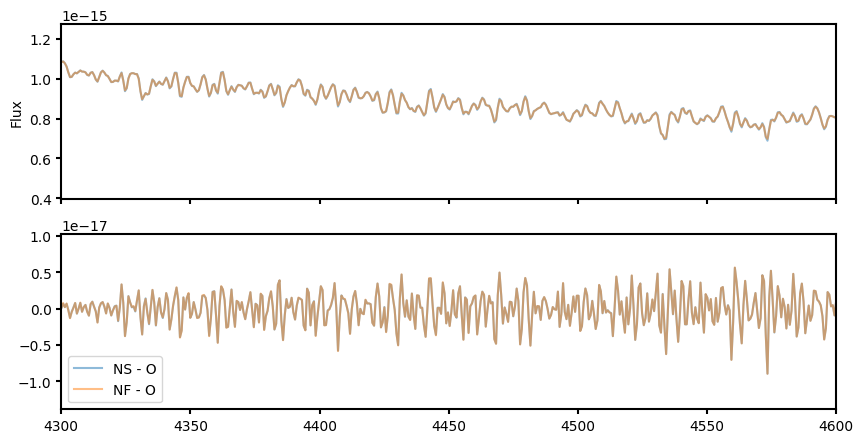

In [ ]:
print(' MK = Multi-Kernel, SK = Single-Kernel, \
    fast = instr_broadening_new_fast,\
    slow = instr_broadening_new,\
    old = instr_broadening_old')

m_spec = ret.m_spec['NIRSpec']

order = 3
wave = ret.d_spec['NIRSpec'].wave[order,0]
flux = np.copy(m_spec.flux[0,order,0])
flux_new = instr_broadening_new(wave, np.copy(flux), out_res=2700, in_res=100e3)
flux_new_fast = instr_broadening_new_fast(wave, np.copy(flux), out_res=2700, in_res=100e3)
flux_old = instr_broadening_old(wave, np.copy(flux), out_res=2700, in_res=100e3)
fig, ax = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
# ax[0].plot(wave, flux, label='Model')
ax[0].plot(wave, flux_new, label='Broadened model', alpha=0.5)
ax[0].plot(wave, flux_old, label='Broadened model old', alpha=0.5)
ax[1].plot(wave, flux_new-flux_old,  alpha=0.5, label='MK_slow - SK')

ax[1].plot(wave, flux_new_fast-flux_old, alpha=0.5, label='MK_fast - SK')

ax[1].legend()
ax[1].set_xlim(4300, 4600)
ax[0].set(ylabel='Flux')

In [17]:
# speed benchmark

%timeit instr_broadening_new(wave, np.copy(flux), out_res=2700, in_res=100e3)
%timeit instr_broadening_new_fast(wave, np.copy(flux), out_res=2700, in_res=100e3)

%timeit instr_broadening_old(wave, np.copy(flux), out_res=2700, in_res=100e3)


25.5 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
237 µs ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
49.4 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
